In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from PIL import Image

from dataset_cifar10 import CIFAR10

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### parameters

In [2]:
random_seed = 123
learning_rate = 0.001
batch_size = 128
epochs = 10

num_features = 32*32
num_classes = 10

grayscale = False

### data

因为官方CIFAR10 dataset需要在线下载，网速很慢。故将官方的CIFAR10 dataset经过稍微修改，以适应自己下载的离线cifar10数据集

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
train_dataset = CIFAR10(root="D:/work/data/Python/cifar10/",
                        train=True,
                        transform=transform,
                        download=False)
test_dataset = CIFAR10(root="D:/work/data/Python/cifar10/",
                        train=False,
                        transform=transform,
                        download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print("images shape: ", images.size())
    print("labels shape: ", labels.size())
    break

images shape:  torch.Size([128, 3, 32, 32])
labels shape:  torch.Size([128])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(random_seed)
for epoch in range(2):
    for batch_idx, (x, y) in enumerate(train_loader):
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

cuda
Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


### model

In [5]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes
        
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=(5, 5), stride=(1, 1)),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

In [6]:
torch.manual_seed(random_seed)

model = LeNet5(num_classes, grayscale)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### train

In [7]:
def accuracy(model, dataloader):
    correct, num_samples = 0, 0
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)
        
        logits, probas = model(features)
        _, predict_labels = torch.max(probas, 1)
        
        num_samples += targets.size(0)
        correct += (predict_labels == targets).sum()
    
    return correct.float() / num_samples * 100

start_time = time.time()
for epoch in range(epochs):
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        
        # forward
        optimizer.zero_grad()
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        
        # backward
        cost.backward()
        
        # update
        optimizer.step()
        
        if (batch_idx + 1) % 50 == 0:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, epochs, batch_idx, 
                     len(train_loader), cost))
model.eval()
with torch.no_grad(): # save memory during inference
    print('Epoch: %03d/%03d | Train: %.3f%%' % (
          epoch+1, epochs, 
          accuracy(model, train_loader)))

Epoch: 001/010 | Batch 0049/0391 | Cost: 2.1016
Epoch: 001/010 | Batch 0099/0391 | Cost: 1.9296
Epoch: 001/010 | Batch 0149/0391 | Cost: 1.7032
Epoch: 001/010 | Batch 0199/0391 | Cost: 1.6132
Epoch: 001/010 | Batch 0249/0391 | Cost: 1.5559
Epoch: 001/010 | Batch 0299/0391 | Cost: 1.7342
Epoch: 001/010 | Batch 0349/0391 | Cost: 1.5572
Epoch: 002/010 | Batch 0049/0391 | Cost: 1.4401
Epoch: 002/010 | Batch 0099/0391 | Cost: 1.5761
Epoch: 002/010 | Batch 0149/0391 | Cost: 1.5709
Epoch: 002/010 | Batch 0199/0391 | Cost: 1.5023
Epoch: 002/010 | Batch 0249/0391 | Cost: 1.7170
Epoch: 002/010 | Batch 0299/0391 | Cost: 1.2766
Epoch: 002/010 | Batch 0349/0391 | Cost: 1.4613
Epoch: 003/010 | Batch 0049/0391 | Cost: 1.1575
Epoch: 003/010 | Batch 0099/0391 | Cost: 1.2323
Epoch: 003/010 | Batch 0149/0391 | Cost: 1.3162
Epoch: 003/010 | Batch 0199/0391 | Cost: 1.3026
Epoch: 003/010 | Batch 0249/0391 | Cost: 1.1919
Epoch: 003/010 | Batch 0299/0391 | Cost: 1.3568
Epoch: 003/010 | Batch 0349/0391 | Cost:

### evaluate

In [8]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (accuracy(model, test_loader)))

Test accuracy: 61.86%


torch.Size([128, 3, 32, 32])
torch.Size([128])
torch.Size([32, 32, 3])


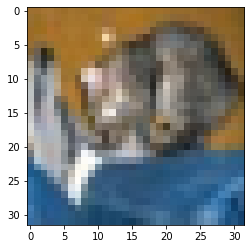

In [9]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break

print(features.size())
print(targets.size())
# CHW -> HWC
hwc_img = np.transpose(features[1], axes=(1, 2, 0))
print(hwc_img.size())
plt.imshow(hwc_img)